# Trabalho Prático 2019/1

Parte dos códigos extraídos de [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Capítulo 9. Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot
from thinkstats2 import RandomSeed

from matplotlib import rc
rc('animation', html='html5')
from Cell2D import Cell2D, Cell2DViewer

## Sugarscape

O código a seguir, além dos módulos importados nas célula anterior permitem implementar o sugarscape.

A função `make_locs` recebe as dimensões da grade e retorna um array onde cada linha é uma coordenada na grade.

In [2]:
def make_locs(n, m):
    """Cria um array onde cada linha é um índice em uma grade `n` por `m`.
    
    n: int número de linhas
    m: int número de colunas
    
    returns: NumPy array
    """
    left = np.repeat(np.arange(m), n)
    right = np.tile(np.arange(n), m)
    return np.transpose([left, right])

`make_visible_locs` recebe o escopo (_range_) de visão de um agente e retorna um array onde cada linha é a coordenada de uma célular visível. As células estão a distâncias cada vez maiores. As células na mesma distância são embaralhadas.

In [3]:
def make_visible_locs(vision):
    """Computa o kernel de células visíveis.
        
    vision: int distância
    """
    def make_array(d):
        """Gera células visíveis com distâncias cada vez maiores."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

A classe a seguir implementa o Sugarscape:

In [4]:
class Sugarscape(Cell2D):
    """Foi modificado nesta classe, no def make_capacity os rows e cows,
       que definem a localização dos picos de açúcar
       caso quisesse mudar o tamanho do raio dos picos basta mudar o (a)
       que recebe o tamanho do raio de cada seção do pico"""
    
    """Representa um Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, **params):
        """Inicializa os atributos.

        n: número de linhas e colunas
        params: dicionário de parâmetros
        """
        self.n = n
        self.params = params
        
        # rastreie variáveis
        self.agent_count_seq = []
    
        # crie o array de capacidade
        self.capacity = self.make_capacity()
        
        # inicialmente todas as células estão na capacidade
        self.array = self.capacity.copy()
        
        # crie os agentes
        self.make_agents()
        
    def make_capacity(self):
        """Cria o array de capacidade."""
        
        # computa a distancia dos picos até cada célula. 
        x = np.arange(self.n)
        rows, cols = np.meshgrid(x, x, indexing='ij')
        
        # cada célula em `rows` contém sua prórpia coordenada `i`
        # cada célula em `cols` contém sua coordenada `j`
        dist1 = np.hypot(rows-35, cols-20)
        dist2 = np.hypot(rows-35, cols-60)
        
        # cada célula em `dist` contém a sua distância para o pico mais próximo
        dist = np.minimum(dist1, dist2)
        
        # células no array de capacidade são definidas de acordo com a distância do pico
        a = np.zeros((self.n, self.n), np.float)
        a[dist<18] = 1
        a[dist<15] = 2
        a[dist<10] = 3
        a[dist<7] = 4

        return a
        
    def make_agents(self):
        """Cria os agentes."""
        
        # determina onde os agentes começam e gera locais
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n,m)
        np.random.shuffle(locs)

        # cria os agentes
        num_agents = self.params.get('num_agents', 400)
        self.agents = [Agent(locs[i], self.params) 
                       for i in range(num_agents)]
        
        # acompanha e registra quais células estão ocupadas
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        """Adiciona açucar para todas as células e as limita pela capacidade."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def look_around(self, center, vision):
        """Encontra a célula visível com a maior quantia de açucar.
        
        center: tupla, coordenadas da célula central
        vision: int, distância visível máxima 
        
        returns: tupla, coordenadas da melhor célula
        """
        # encontra todas as células visíveis
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # converte linhas do array para tuplas
        locs = [tuple(loc) for loc in locs]
        
        # seleciona células desocupadas
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # se todas as células visíveis estiverem ocupadas, espere
        if len(empty_locs) == 0:
            return center
        
        # procure o nível de açucar em cada célula
        t = [self.array[loc] for loc in empty_locs]
        
        # encontre o melhor e retorne-o
        # (no caso de um empate, argmax retorna o primeiro, que
        # é o mais próximo)
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
        """Remove e retorna o açucar de `loc`.
        
        loc: tupla de coordenadas
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def step(self):
        """Executa um passo temporal."""
        replace = self.params.get('replace', False)
        
        # varra os agentes em ordem aleatória
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            # marque a célula atual como desocupada
            self.occupied.remove(agent.loc)
            
            # execute um passo
            agent.step(self)

            # se o agente estiver morto, remova-o da lista
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # caso contrário marque a sua célula como ocupada
                self.occupied.add(agent.loc)

        # atualize as séries de tempo
        self.agent_count_seq.append(len(self.agents))
        
        # cresça um pouco do açucar novamente
        self.grow()
        return len(self.agents)
    
    def add_agent(self):
        """Gera um novo agente aleatório.
                
        returns: novo Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        """Escolha uma célula desocupada aleatória.
        
        returns: tupla de coordenadas
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

Segue o visualizador que mostra o estado do Sugarscape.

In [5]:
class SugarscapeViewer(Cell2DViewer):
    """Gera uma visualização e animação de Sugarscape."""
    
    cmap = plt.get_cmap('YlOrRd')
    
    options = dict(interpolation='none', alpha=0.8,
                   vmin=0, vmax=9)
    
    def draw(self, grid=False):
        """Desenha o array e quaiquer outros elementos.
        
        grid: booleano, se terá que desenha as linhas da grade
        """
        self.draw_array(self.viewee.array, origin='lower')
        self.draw_agents()

    def draw_agents(self):      
        """Para modificar a cor dos agentes de vermelho
           para azul basta modificar a atribuição de cor
           na função que desenha cada agente"""
        
        """Desenha os agentes.
        """
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='black')[0]
        
    def animate_func(self, i):
        """Desenha um quadro da animação."""
        Cell2DViewer.animate_func(self, i)
        xs, ys = self.get_coords()
        self.points.set_data(np.array([xs, ys]))
        return self.im, self.points
    
    def get_coords(self):
        """Pega as coordenadas dos agentes.
        
        Transforma de (row, col) para (x, y).
        
        returns: tupla de sequências, (xs, ys)
        """
        agents = self.viewee.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

Segue a implementação dos agentes.

In [6]:
class Agent:
    
    def __init__(self, loc, params):
        """Cria um novo agente no dado local.
        
        loc: tupla de coordenadas
        params: dicionário de parâmetros
        """
        self.loc = tuple(loc)
        self.age = 0

        # extrai os parâmetros

        
        max_vision = params.get('max_vision', 6)
        max_metabolism = params.get('max_metabolism', 4)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)
        
        # escolhe os atributos
        self.vision = np.random.random_integers(max_vision)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)

    def step(self, env):
        """Olhe em volta, mova, e colete.
        
        env: Sugarscape
        """
        self.loc = env.look_around(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checa se o açucar ficou negativo."""
        return self.sugar < 0
    
    def is_old(self):
        """Checa se a vida útil foi excedida."""
        return self.age > self.lifespan

## Migração em ondas

Vimos anteriormente que no cenário anterior, se começarmos com todos os agentes no canto inferior esquerdo, eles se propagarão para cima e para a direita em ondas. O código que segue implementa este caso.

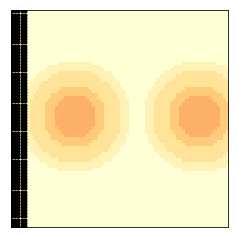

In [7]:
RandomSeed(17)

env = Sugarscape(70, num_agents=350, starting_box=(5, 70), max_vision=18)              
"""A modificação feita nesta parte
   do código, refere-se ao tamanho
   do grid(correspondente ao primeiro 
   parametro) e tamanho do campo visual 
   maximo para 18(apenas para que alguns
   agentes cheguem mais rápido ao pico)"""
    
viewer = SugarscapeViewer(env)
anim = viewer.animate(frames=40, interval=600)

In [8]:
anim

Segue o cenário após 6 e 12 passos.

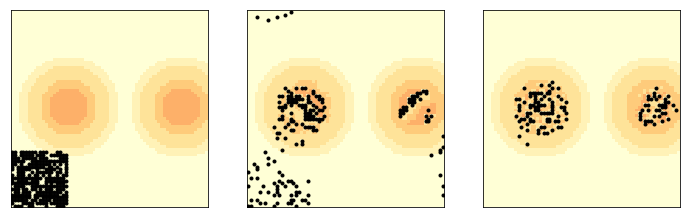

In [9]:
env = Sugarscape(70, num_agents=300, starting_box=(20, 20), max_vision=20)
    
viewer = SugarscapeViewer(env)

thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
for i in range(7):
    viewer.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(20):
    viewer.step()
viewer.draw()

plt.savefig('chap09-5.pdf')

## TAREFA
Reimplemente o cenário de migração de ondas mudando o tamanho da área do mundo e fazendo com que os dois focos circulares de açucar fiquem alinha horizontalmente um com o outro. Coloque todos os agentes no lado esquerdo ou direito do cenário. É possível observar algum comportamento emergente? Ocorre também a migração em ondas? Discuta os resultados.

In [10]:
## solução aqui
""""Para modificar o tamanho do Sugarscape basta na chamada 
env = Sugarscape(70, num_agents=300, starting_box=(5, 70), max_vision=20), alterar o primeiro parametro que define o tamanho
do array n por n correspondente ao número de "caixas", dentro do sugarscape que corresponde ao tamanho.
já para a localização dos picos de açúcar ficarem em alinha horizontal foi necessário modificar a função 
    def make_capacity(self):
...
        # cada célula em `rows` contém sua própia coordenada `i`
        # cada célula em `cols` contém sua coordenada `j`
        dist1 = np.hypot(rows-35, cols-20)              modificando as cordenadas dos dois picos de açúcar
        dist2 = np.hypot(rows-35, cols-60)...
        
Sim apresenta comportamento de onda 
_______Se começarmos com todos os agentes no canto esquerdo em coluna,
eles rapidamente se moverão em direção ao “pico” mais próximo de células de alta capacidade de açúucar,
apesar de não haver nenhum atributo que define sua ida para os picos do grid. 
_______Uma propriedade interessante dessas ondas é que elas se movem na diagonal, o que pode ser surpreendente,
porque os próprios agentes só se movem para o norte ou para o leste, nunca para o nordeste.

Sim apresenta comportamento emergente
_______Uma propriedade emergente é uma característica de um sistema que resulta da interação de seus componentes
e não de suas propriedades
_______mas é um exemplo fraco, 
porque poderíamos razoavelmente prevê-lo com base nas distribuições de alcance de visão,
metabolismo e expectativa de vida
"""
        
    

'"Para modificar o tamanho do Sugarscape basta na chamada \nenv = Sugarscape(70, num_agents=300, starting_box=(5, 70), max_vision=20), alterar o primeiro parametro que define o tamanho\ndo array n por n correspondente ao número de "caixas", dentro do sugarscape que corresponde ao tamanho.\njá para a localização dos picos de açúcar ficarem em alinha horizontal foi necessário modificar a função \n    def make_capacity(self):\n...\n        # cada célula em `rows` contém sua própia coordenada `i`\n        # cada célula em `cols` contém sua coordenada `j`\n        dist1 = np.hypot(rows-35, cols-20)              modificando as cordenadas dos dois picos de açúcar\n        dist2 = np.hypot(rows-35, cols-60)...\n        \nSim apresenta comportamento de onda \n_______Se começarmos com todos os agentes no canto esquerdo em coluna,\neles rapidamente\xa0se moverão em direção ao “pico” mais próximo de células de alta\xa0capacidade de açúucar,\napesar de não haver nenhum atributo que define sua ida p

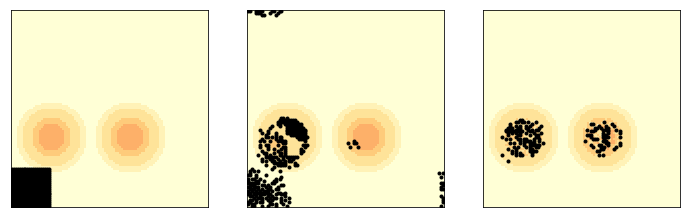

In [11]:
viler = Sugarscape(100, num_agents=400, starting_box=(20, 20), max_vision=30)
    
viewer = SugarscapeViewer(viler)

thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
for i in range(3):
    viewer.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(20):
    viewer.step()
viewer.draw()

plt.savefig('chap09-5.pdf')